# Exploration Data Analisys for World Bank datasets

В ходе данного занятия мы подготовить EDA для датасета **World Bank** и подготовим все необходимое для реализации ETL.

**Данные:**

[World Bank Indicator Data](https://data.worldbank.org/indicator) - Данные социально-экономических индикаторов для стран по всему миру. Как пример индикаторов можно привести популяцию (население).

[World Bank Project Data](https://datacatalog.worldbank.org/dataset/world-bank-projects-operations) - Данные проектов различных стран начиная с 1947 года.

#### В ходе данного занятия мы пройдем следующие этапы:
**Извлечение данных из разных источников:**
- csv
- json
- Базы данных

**Преобразование данных**
- Обхединения данных из различных источников
- Отчистка данных
- Парсинг дат
- Заполнение пропусков
- Работа с дубликатами
- Удаление незначимых переменных
- Выбросы в данных

**Формирование выходной таблицы**
- Построим таблицу, которую можно использовать для обучения моделей

**Цель ноутбука**
- Подготовить несколько гипотез для этапа преобразования данных
- Подготовить скрипты для реализации ETL-пайплайна

## Imports

In [1]:
from collections import defaultdict
import os
import sys
import json
import logging
from typing import Dict, List
from datetime import datetime

import sqlite3
import numpy as np
import pandas as pd
from pycountry import countries
from dotenv import load_dotenv
from sqlalchemy import (
    Table, Column, DateTime, Float, Integer,
    MetaData, String, UniqueConstraint, create_engine, inspect)

In [2]:
os.chdir("../")

In [3]:
logging.basicConfig(level=logging.INFO, filename="py_log.log", filemode="w",
                    format="%(asctime)s %(levelname)s %(message)s")
LOG_FORMAT  = f'WB_DATA ETL - '

---

In [4]:
def _create_engine(source: str):
        load_dotenv()
        host = os.environ.get(f'DB_{source}_HOST')
        port = os.environ.get(f'DB_{source}_PORT')
        username = os.environ.get(f'DB_{source}_USER')
        password = os.environ.get(f'DB_{source}_PASSWORD')
        db = os.environ.get(f'DB_{source}_NAME')
        
        return create_engine(
            f'postgresql://{username}:{password}@{host}:{port}/{db}')

## Extract

In [5]:
logging.info(LOG_FORMAT + 'Start the extract part')
# Engines
logging.info(LOG_FORMAT + 'Connect to DataBases')

engine_psql = _create_engine('SOURCE')
engine_sqlite = create_engine('sqlite:///data/preprocess_data/population_data.db')

In [6]:
# Selection Template
sql_template = "select * from {}"

In [7]:
# Extract data from different datasources
logging.info(LOG_FORMAT + 'Extract data')

logging.info(LOG_FORMAT + 'Extract population data')

with open('data/preprocess_data/population_data_1960_1980.json', 'r') as f:
    df_population_first = pd.read_json(f)

df_population_second  = pd.read_sql('population_data', engine_sqlite)
df_population_third = pd.read_sql(
    sql_template.format('s1w1_population_data_2001_2017'), engine_psql)

### Explore

In [8]:
df_population_first.shape

(264, 25)

In [9]:
df_population_first.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,59440.0,59840.0,60243.0,60528.0,60657.0,60586.0,60366.0,60103.0,59980.0,60096.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,11417825.0,11721940.0,12027822.0,12321541.0,12590286.0,12840299.0,13067538.0,13237734.0,13306695.0,13248370.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,6927269.0,7094834.0,7277960.0,7474338.0,7682479.0,7900997.0,8130988.0,8376147.0,8641521.0,8929900.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2187853.0,2243126.0,2296752.0,2350124.0,2404831.0,2458526.0,2513546.0,2566266.0,2617832.0,2671997.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,25559.0,26892.0,28232.0,29520.0,30705.0,31777.0,32771.0,33737.0,34818.0,36067.0


In [10]:
df_population_second.shape

(264, 24)

In [11]:
df_population_second.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1981,1982,1983,1984,1985,1986,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
0,Aruba,ABW,"Population, total",SP.POP.TOTL,60567,61345,62201,62836,63026,62644,...,64622,68235,72504,76700,80324,83200,85451,87277,89005,90853
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,13053954,12749645,12389269,12047115,11783050,11601041,...,12993657,13981231,15095099,16172719,17099541,17822884,18381605,18863999,19403676,20093756
2,Angola,AGO,"Population, total",SP.POP.TOTL,9244507,9582156,9931562,10277321,10609042,10921037,...,12553446,12968345,13403734,13841301,14268994,14682284,15088981,15504318,15949766,16440924
3,Albania,ALB,"Population, total",SP.POP.TOTL,2726056,2784278,2843960,2904429,2964762,3022635,...,3266790,3247039,3227287,3207536,3187784,3168033,3148281,3128530,3108778,3089027
4,Andorra,AND,"Population, total",SP.POP.TOTL,37500,39114,40867,42706,44600,46517,...,56671,58888,60971,62677,63850,64360,64327,64142,64370,65390


In [12]:
df_population_third.shape

(264, 22)

In [13]:
df_population_third.head()

,index,Country Name,Country Code,Indicator Name,Indicator Code,2001,2002,2003,2004,2005,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,0,Aruba,ABW,"Population, total",SP.POP.TOTL,92898.0,94992.0,97017.0,98737.0,100031.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,20966463.0,21979923.0,23064851.0,24118979.0,25070798.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,2,Angola,AGO,"Population, total",SP.POP.TOTL,16983266.0,17572649.0,18203369.0,18865716.0,19552542.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,3,Albania,ALB,"Population, total",SP.POP.TOTL,3060173.0,3051010.0,3039616.0,3026939.0,3011487.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,4,Andorra,AND,"Population, total",SP.POP.TOTL,67341.0,70049.0,73182.0,76244.0,78867.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0


---

In [14]:
logging.info(LOG_FORMAT + 'Merge population data')
df_population = df_population_first.merge(
    df_population_second.merge(
        df_population_third,
        on=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
        how='left'
    ),
    on=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
    how='left'
)

In [15]:
df_population.shape

(264, 63)

In [16]:
df_population.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0


<Axes: >

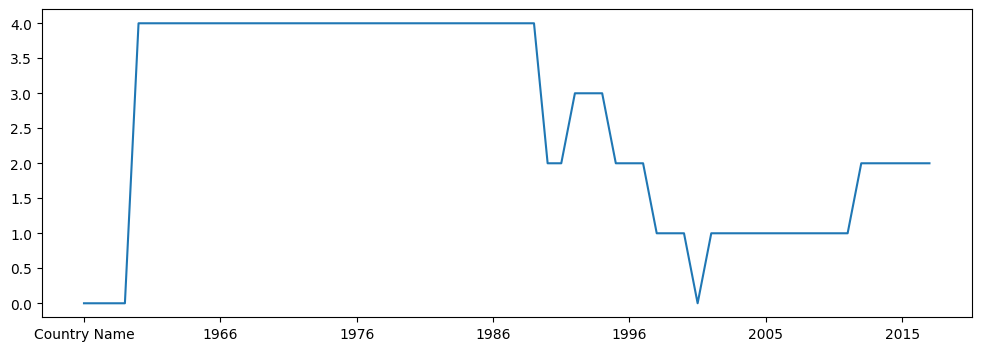

In [17]:
df_population.isna().sum().plot(figsize=(12,4))

In [18]:
logging.info(LOG_FORMAT + 'Extract other data')

df_rural = pd.read_sql(sql_template.format('s1w1_rural_population_percent'), engine_psql)
df_electricity = pd.read_sql(sql_template.format('s1w1_electricity_access_percent'), engine_psql)
df_project = pd.read_sql(sql_template.format('s1w1_projects_data'), engine_psql)
df_vvp = pd.read_sql(sql_template.format('s1w1_vvp_data'), engine_psql)

with open('data/preprocess_data/country_not_found_mapping.json', 'r') as f:
    country_not_found_mapping = json.load(f)
with open('data/preprocess_data/non_countries.json', 'r') as f:
    non_countries = json.load(f)

### Explore

In [19]:
df_rural.shape

(264, 63)

In [20]:
df_rural.head()

,index,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,0,Aruba,ABW,Rural population (% of total population),SP.RUR.TOTL.ZS,49.224,49.239,49.254,49.270,49.285,...,56.217,56.579,56.941,57.302,57.636,57.942,58.221,58.472,58.696,58.893
1,1,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,91.779,91.492,91.195,90.890,90.574,...,76.054,75.687,75.311,74.926,74.532,74.129,73.718,73.297,72.868,72.430
2,2,Angola,AGO,Rural population (% of total population),SP.RUR.TOTL.ZS,89.565,89.202,88.796,88.376,87.942,...,61.491,60.701,59.903,59.100,58.301,57.510,56.726,55.950,55.181,54.422
3,3,Albania,ALB,Rural population (% of total population),SP.RUR.TOTL.ZS,69.295,69.057,68.985,68.914,68.842,...,50.009,48.924,47.837,46.753,45.670,44.617,43.591,42.593,41.624,40.684
4,4,Andorra,AND,Rural population (% of total population),SP.RUR.TOTL.ZS,41.550,39.017,36.538,34.128,31.795,...,11.133,11.648,12.183,12.740,13.292,13.835,14.367,14.885,15.388,15.873


In [21]:
df_electricity.shape

(264, 63)

In [22]:
df_electricity.head()

,index,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,0,Aruba,ABW,Access to electricity (% of population),EG.ELC.ACCS.ZS,None,None,None,None,None,...,93.086170,93.354546,93.35629,93.942375,94.255810,94.57826,94.90672,95.23818,95.570145,None
1,1,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,None,None,None,None,None,...,42.400000,44.854885,42.70000,43.222020,69.100000,67.25955,89.50000,71.50000,84.137140,None
2,2,Angola,AGO,Access to electricity (% of population),EG.ELC.ACCS.ZS,None,None,None,None,None,...,31.268013,32.382470,33.51495,34.600000,35.821964,36.99049,32.00000,42.00000,40.520607,None
3,3,Albania,ALB,Access to electricity (% of population),EG.ELC.ACCS.ZS,None,None,None,None,None,...,100.000000,100.000000,100.00000,100.000000,100.000000,100.00000,100.00000,100.00000,100.000000,None
4,4,Andorra,AND,Access to electricity (% of population),EG.ELC.ACCS.ZS,None,None,None,None,None,...,100.000000,100.000000,100.00000,100.000000,100.000000,100.00000,100.00000,100.00000,100.000000,None


In [23]:
df_project.shape

(18248, 58)

In [24]:
df_project.head()

,index,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,...,mjtheme3name,mjtheme4name,mjtheme5name,location,GeoLocID,GeoLocName,Latitude,Longitude,Country,null
0,0,P162228,Other,World;World,RE,Investment Project Financing,IN,C,N,L,...,None,None,None,None,None,None,None,None,None,None
1,1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Investment Project Financing,IN,B,N,L,...,None,None,None,None,None,None,None,None,None,None
2,2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,PE,Investment Project Financing,IN,None,Y,L,...,None,None,None,None,None,None,None,None,None,None
3,3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Investment Project Financing,IN,A,N,L,...,None,None,None,None,None,None,None,None,None,None
4,4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,B,N,L,...,None,None,None,0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...,0002327546;0002328925;0002565340;0002565343;00...,Ogun State;Niger State;Abia State;Edo;Kebbi St...,7;10;5.41667;6.5;11.5;8,3.58333;6;7.5;6;4;10.5,NG;NG;NG;NG;NG;NG,None


In [25]:
df_vvp.shape

(264, 63)

In [26]:
df_vvp.head()

,index,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,...,2.791961e+09,2.498933e+09,2.467704e+09,2.584464e+09,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,537777800.0,548888900.0,546666700.0,751111170.0,800000060.0,...,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.026425e+10,2.061610e+10,1.921556e+10,1.946902e+10,2.081530e+10
2,2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,...,8.417804e+10,7.549238e+10,8.252614e+10,1.041158e+11,1.139232e+11,1.249125e+11,1.267302e+11,1.026212e+11,9.533720e+10,1.242094e+11
3,3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,...,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.138693e+10,1.188368e+10,1.303935e+10
4,4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,...,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811490e+09,2.877312e+09,3.012914e+09


In [27]:
len(country_not_found_mapping)

35

In [28]:
country_not_found_mapping

{'Co-operative Republic of Guyana': 'GUY',
 'Commonwealth of Australia': 'AUS',
 'Democratic Republic of Sao Tome and Prin': 'STP',
 'Democratic Republic of the Congo': 'COD',
 'Democratic Socialist Republic of Sri Lan': 'LKA',
 'East Asia and Pacific': 'EAS',
 'Europe and Central Asia': 'ECS',
 'Islamic  Republic of Afghanistan': 'AFG',
 'Latin America': 'LCN',
 'Caribbean': 'LCN',
 'Macedonia': 'MKD',
 'Middle East and North Africa': 'MEA',
 'Oriental Republic of Uruguay': 'URY',
 'Republic of Congo': 'COG',
 "Republic of Cote d'Ivoire": 'CIV',
 'Republic of Korea': 'KOR',
 'Republic of Niger': 'NER',
 'Republic of Kosovo': 'XKX',
 'Republic of Rwanda': 'RWA',
 'Republic of The Gambia': 'GMB',
 'Republic of Togo': 'TGO',
 'Republic of the Union of Myanmar': 'MMR',
 'Republica Bolivariana de Venezuela': 'VEN',
 'Sint Maarten': 'SXM',
 "Socialist People's Libyan Arab Jamahiriy": 'LBY',
 'Socialist Republic of Vietnam': 'VNM',
 'Somali Democratic Republic': 'SOM',
 'South Asia': 'SAS',


In [29]:
non_countries.keys()

dict_keys(['non_countries'])

In [30]:
len(non_countries["non_countries"])

47

In [31]:
non_countries["non_countries"]

['World',
 'High income',
 'OECD members',
 'Post-demographic dividend',
 'IDA & IBRD total',
 'Low & middle income',
 'Middle income',
 'IBRD only',
 'East Asia & Pacific',
 'Europe & Central Asia',
 'North America',
 'Upper middle income',
 'Late-demographic dividend',
 'European Union',
 'East Asia & Pacific (excluding high income)',
 'East Asia & Pacific (IDA & IBRD countries)',
 'Euro area',
 'Early-demographic dividend',
 'Lower middle income',
 'Latin America & Caribbean',
 'Latin America & the Caribbean (IDA & IBRD countries)',
 'Latin America & Caribbean (excluding high income)',
 'Europe & Central Asia (IDA & IBRD countries)',
 'Middle East & North Africa',
 'Europe & Central Asia (excluding high income)',
 'South Asia (IDA & IBRD)',
 'South Asia',
 'Arab World',
 'IDA total',
 'Sub-Saharan Africa',
 'Sub-Saharan Africa (IDA & IBRD countries)',
 'Sub-Saharan Africa (excluding high income)',
 'Middle East & North Africa (excluding high income)',
 'Middle East & North Africa (I

---

## Transform

### def transform_projects

In [32]:
df_project.head()

,index,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,...,mjtheme3name,mjtheme4name,mjtheme5name,location,GeoLocID,GeoLocName,Latitude,Longitude,Country,null
0,0,P162228,Other,World;World,RE,Investment Project Financing,IN,C,N,L,...,None,None,None,None,None,None,None,None,None,None
1,1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Investment Project Financing,IN,B,N,L,...,None,None,None,None,None,None,None,None,None,None
2,2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,PE,Investment Project Financing,IN,None,Y,L,...,None,None,None,None,None,None,None,None,None,None
3,3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Investment Project Financing,IN,A,N,L,...,None,None,None,None,None,None,None,None,None,None
4,4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,B,N,L,...,None,None,None,0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...,0002327546;0002328925;0002565340;0002565343;00...,Ogun State;Niger State;Abia State;Edo;Kebbi St...,7;10;5.41667;6.5;11.5;8,3.58333;6;7.5;6;4;10.5,NG;NG;NG;NG;NG;NG,None


In [33]:
logging.info(LOG_FORMAT +  'Transform projects dataset')

In [34]:
df_project['countryname'] = df_project['countryname'].str.split(';').str.get(0)
df_project['countryname']

0                                   World
1        Democratic Republic of the Congo
2         People's Republic of Bangladesh
3        Islamic  Republic of Afghanistan
4             Federal Republic of Nigeria
                       ...               
18243                   Republic of Chile
18244           Grand Duchy of Luxembourg
18245                  Kingdom of Denmark
18246          Kingdom of the Netherlands
18247                     French Republic
Name: countryname, Length: 18248, dtype: object

In [35]:
project_country_abbrev_dict = defaultdict(str)
for country in df_project['countryname'].drop_duplicates().sort_values():
    try:
        project_country_abbrev_dict[country] = countries.lookup(country).alpha_3
    except: 
        continue
project_country_abbrev_dict.update(country_not_found_mapping)

In [36]:
project_country_abbrev_dict

defaultdict(str,
            {'American Samoa': 'ASM',
             'Antigua and Barbuda': 'ATG',
             'Arab Republic of Egypt': 'EGY',
             'Argentine Republic': 'ARG',
             'Barbados': 'BRB',
             'Belize': 'BLZ',
             'Bosnia and Herzegovina': 'BIH',
             'Burkina Faso': 'BFA',
             'Central African Republic': 'CAF',
             'Commonwealth of Dominica': 'DMA',
             'Commonwealth of The Bahamas': 'BHS',
             'Czech Republic': 'CZE',
             'Democratic Republic of Timor-Leste': 'TLS',
             'Dominican Republic': 'DOM',
             'Federal Democratic Republic of Ethiopia': 'ETH',
             'Federal Republic of Nigeria': 'NGA',
             'Federated States of Micronesia': 'FSM',
             'Federative Republic of Brazil': 'BRA',
             'French Republic': 'FRA',
             'Gabonese Republic': 'GAB',
             'Georgia': 'GEO',
             'Grand Duchy of Luxembourg': 'LUX',
    

In [37]:
df_project['countrycode'] = df_project['countryname'].map(project_country_abbrev_dict)
df_project['countrycode']

0        WLD
1        COD
2        BGD
3        AFG
4        NGA
        ... 
18243    CHL
18244    LUX
18245    DNK
18246    NLD
18247    FRA
Name: countrycode, Length: 18248, dtype: object

In [38]:
df_project[["boardapprovaldate", "closingdate"]].head()

,boardapprovaldate,closingdate
0,2018-06-28T00:00:00Z,None
1,2018-06-28T00:00:00Z,2023-12-31T00:00:00Z
2,2018-06-28T00:00:00Z,None
3,2018-06-27T00:00:00Z,2023-06-28T00:00:00Z
4,2018-06-27T00:00:00Z,2023-05-31T00:00:00Z


In [39]:
df_project['boardapprovaldate'] = pd.to_datetime(df_project['boardapprovaldate'])
df_project['closingdate'] = pd.to_datetime(df_project['closingdate'])
df_project['year'] = df_project['boardapprovaldate'].dt.year
df_project['year_close'] = df_project['closingdate'].dt.year
df_project.fillna('', inplace=True)

/tmp/ipykernel_5359/1892632786.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_project.fillna('', inplace=True)


In [40]:
df_project.head()

,index,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,...,location,GeoLocID,GeoLocName,Latitude,Longitude,Country,null,countrycode,year,year_close
0,0,P162228,Other,World,RE,Investment Project Financing,IN,C,N,L,...,,,,,,,,WLD,2018.0,
1,1,P163962,Africa,Democratic Republic of the Congo,PE,Investment Project Financing,IN,B,N,L,...,,,,,,,,COD,2018.0,2023.0
2,2,P167672,South Asia,People's Republic of Bangladesh,PE,Investment Project Financing,IN,,Y,L,...,,,,,,,,BGD,2018.0,
3,3,P158768,South Asia,Islamic Republic of Afghanistan,PE,Investment Project Financing,IN,A,N,L,...,,,,,,,,AFG,2018.0,2023.0
4,4,P161364,Africa,Federal Republic of Nigeria,PE,Investment Project Financing,IN,B,N,L,...,0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...,0002327546;0002328925;0002565340;0002565343;00...,Ogun State;Niger State;Abia State;Edo;Kebbi St...,7;10;5.41667;6.5;11.5;8,3.58333;6;7.5;6;4;10.5,NG;NG;NG;NG;NG;NG,,NGA,2018.0,2023.0


In [41]:
df_project.shape

(18248, 61)

In [42]:
df_project = df_project[df_project.countrycode != '']
df_project.shape


(17419, 61)

In [43]:
df_project['target'] = (df_project.year_close != '').astype(int)
df_project['target']

0        0
1        1
2        0
3        1
4        1
        ..
18243    1
18244    1
18245    1
18246    1
18247    1
Name: target, Length: 17419, dtype: int64

In [44]:
df_project['year'] = df_project['year'].astype(str).str.slice(stop=4)
df_project['year_close'] = df_project['year_close'].astype(str).str.slice(stop=4)

In [45]:
df_project['sector1'].head(10)

0                           !$!0
1                           !$!0
2                           !$!0
3                           !$!0
4    Social Protection!$!63!$!SA
5                           !$!0
6                           !$!0
7                           !$!0
8                           !$!0
9                           !$!0
Name: sector1, dtype: object

In [46]:
df_project['sector1'] = df_project['sector1'].replace('!$!0', np.nan)
df_project['sector1'] = df_project['sector1'].replace('!.+', '', regex=True)
df_project['sector1'] = df_project['sector1'].replace('^(\(Historic\))', '', regex=True)

In [47]:
df_project['sector1'].head(10)

0                  NaN
1                  NaN
2                  NaN
3                  NaN
4    Social Protection
5                  NaN
6                  NaN
7                  NaN
8                  NaN
9                  NaN
Name: sector1, dtype: object

In [48]:
df_project.shape

(17419, 62)

In [49]:
df_project = df_project[~df_project['countryname'].isin(non_countries)]

In [50]:
df_project.shape

(17419, 62)

In [51]:
df_project[['id', 'countryname', 'sector1', 'countrycode', 'totalamt', 'year', 'year_close', 'target']]

,id,countryname,sector1,countrycode,totalamt,year,year_close,target
0,P162228,World,NaN,WLD,0,2018,,0
1,P163962,Democratic Republic of the Congo,NaN,COD,"200,000,000",2018,2023,1
2,P167672,People's Republic of Bangladesh,NaN,BGD,"58,330,000",2018,,0
3,P158768,Islamic Republic of Afghanistan,NaN,AFG,"20,000,000",2018,2023,1
4,P161364,Federal Republic of Nigeria,Social Protection,NGA,"100,000,000",2018,2023,1
...,...,...,...,...,...,...,...,...
18243,P006578,Republic of Chile,Hydro,CHL,"13,500,000",1948,1954,1
18244,P037451,Grand Duchy of Luxembourg,Economic management,LUX,"12,000,000",1947,1949,1
18245,P037362,Kingdom of Denmark,Economic management,DNK,"40,000,000",1947,1949,1
18246,P037452,Kingdom of the Netherlands,Economic management,NLD,"195,000,000",1947,1948,1


In [52]:
df_project["totalamt"] = df_project["totalamt"].str.replace(",","").astype(int)

In [53]:
df_project = df_project[['id', 'countryname', 'sector1', 'countrycode', 'totalamt', 'year', 'year_close', 'target']]

In [54]:
df_project

,id,countryname,sector1,countrycode,totalamt,year,year_close,target
0,P162228,World,NaN,WLD,0,2018,,0
1,P163962,Democratic Republic of the Congo,NaN,COD,200000000,2018,2023,1
2,P167672,People's Republic of Bangladesh,NaN,BGD,58330000,2018,,0
3,P158768,Islamic Republic of Afghanistan,NaN,AFG,20000000,2018,2023,1
4,P161364,Federal Republic of Nigeria,Social Protection,NGA,100000000,2018,2023,1
...,...,...,...,...,...,...,...,...
18243,P006578,Republic of Chile,Hydro,CHL,13500000,1948,1954,1
18244,P037451,Grand Duchy of Luxembourg,Economic management,LUX,12000000,1947,1949,1
18245,P037362,Kingdom of Denmark,Economic management,DNK,40000000,1947,1949,1
18246,P037452,Kingdom of the Netherlands,Economic management,NLD,195000000,1947,1948,1


### transform other

In [55]:
def transform_other(df: pd.DataFrame, non_countries: List[str], target_column: str)  -> pd.DataFrame:
    df.drop(columns=['Indicator Name', 'Indicator Code'], inplace=True)
    df.drop_duplicates(subset=['Country Name', 'Country Code'], inplace=True)
    df_melt = df.melt(
        id_vars=['Country Name', 'Country Code'],
        var_name='year',
        value_name=f'{target_column}'
    )
    df_melt[f'{target_column}'] = (
        df_melt.sort_values('year')
                .groupby(['Country Name', 'Country Code'])[f'{target_column}']
                .fillna(method='ffill')
                .fillna(method='bfill')
    )
    df_melt = df_melt[~df_melt['Country Name'].isin(non_countries)]
    return df_melt

In [56]:
df_vvp.head(3)

,index,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,...,2.791961e+09,2.498933e+09,2.467704e+09,2.584464e+09,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,537777800.0,548888900.0,546666700.0,751111170.0,800000060.0,...,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.026425e+10,2.061610e+10,1.921556e+10,1.946902e+10,2.081530e+10
2,2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,...,8.417804e+10,7.549238e+10,8.252614e+10,1.041158e+11,1.139232e+11,1.249125e+11,1.267302e+11,1.026212e+11,9.533720e+10,1.242094e+11


In [57]:
df_population.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0


In [58]:
logging.info(LOG_FORMAT + 'Transform other')
df_vvp = transform_other(df_vvp, non_countries, 'vvp')
df_population  = transform_other(df_population, non_countries, 'population')

/tmp/ipykernel_5359/755657093.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_melt.sort_values('year')
/tmp/ipykernel_5359/755657093.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_melt.sort_values('year')


In [62]:
df_vvp.head()

,Country Name,Country Code,year,vvp
0,Aruba,ABW,index,0.0
1,Afghanistan,AFG,index,1.0
2,Angola,AGO,index,2.0
3,Albania,ALB,index,3.0
4,Andorra,AND,index,4.0


In [63]:
df_population.head()

,Country Name,Country Code,year,population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0


In [64]:
df_electricity.head(3)

,index,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,0,Aruba,ABW,Access to electricity (% of population),EG.ELC.ACCS.ZS,None,None,None,None,None,...,93.086170,93.354546,93.35629,93.942375,94.255810,94.57826,94.90672,95.23818,95.570145,None
1,1,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,None,None,None,None,None,...,42.400000,44.854885,42.70000,43.222020,69.100000,67.25955,89.50000,71.50000,84.137140,None
2,2,Angola,AGO,Access to electricity (% of population),EG.ELC.ACCS.ZS,None,None,None,None,None,...,31.268013,32.382470,33.51495,34.600000,35.821964,36.99049,32.00000,42.00000,40.520607,None


In [65]:
df_rural.head(3)

,index,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,0,Aruba,ABW,Rural population (% of total population),SP.RUR.TOTL.ZS,49.224,49.239,49.254,49.270,49.285,...,56.217,56.579,56.941,57.302,57.636,57.942,58.221,58.472,58.696,58.893
1,1,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,91.779,91.492,91.195,90.890,90.574,...,76.054,75.687,75.311,74.926,74.532,74.129,73.718,73.297,72.868,72.430
2,2,Angola,AGO,Rural population (% of total population),SP.RUR.TOTL.ZS,89.565,89.202,88.796,88.376,87.942,...,61.491,60.701,59.903,59.100,58.301,57.510,56.726,55.950,55.181,54.422


In [66]:
logging.info(LOG_FORMAT + 'Transform other')
df_electricity = transform_other(df_electricity, non_countries, 'electricity')
df_rural  = transform_other(df_rural, non_countries, 'population_rural')

/tmp/ipykernel_5359/755657093.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_melt.sort_values('year')
/tmp/ipykernel_5359/755657093.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_melt.sort_values('year')


In [67]:
df_electricity.head()

,Country Name,Country Code,year,electricity
0,Aruba,ABW,index,0.0
1,Afghanistan,AFG,index,1.0
2,Angola,AGO,index,2.0
3,Albania,ALB,index,3.0
4,Andorra,AND,index,4.0


In [68]:
df_rural.head()

,Country Name,Country Code,year,population_rural
0,Aruba,ABW,index,0.0
1,Afghanistan,AFG,index,1.0
2,Angola,AGO,index,2.0
3,Albania,ALB,index,3.0
4,Andorra,AND,index,4.0


In [69]:
df_vvp.merge(
    df_population,
    on=('Country Name', 'Country Code', 'year'),
)

,Country Name,Country Code,year,vvp,population
0,Aruba,ABW,index,0.000000e+00,0
1,Afghanistan,AFG,index,1.000000e+00,1
2,Angola,AGO,index,2.000000e+00,2
3,Albania,ALB,index,3.000000e+00,3
4,Andorra,AND,index,4.000000e+00,4
...,...,...,...,...,...
15571,Kosovo,XKX,2017,7.128691e+09,1830700.0
15572,"Yemen, Rep.",YEM,2017,1.821333e+10,28250420.0
15573,South Africa,ZAF,2017,3.494193e+11,56717156.0
15574,Zambia,ZMB,2017,2.580867e+10,17094130.0


In [70]:
df_indicator = (
    df_vvp
    .merge(
        df_population,
        on=('Country Name', 'Country Code', 'year'),
    )
    .merge(
        df_electricity,
        on=('Country Name', 'Country Code', 'year'),
    )
    .merge(
        df_rural,
        on=('Country Name', 'Country Code', 'year'),
    )
)

In [71]:
df_indicator

,Country Name,Country Code,year,vvp,population,electricity,population_rural
0,Aruba,ABW,index,0.000000e+00,0,0.000000,0.000
1,Afghanistan,AFG,index,1.000000e+00,1,1.000000,1.000
2,Angola,AGO,index,2.000000e+00,2,2.000000,2.000
3,Albania,ALB,index,3.000000e+00,3,3.000000,3.000
4,Andorra,AND,index,4.000000e+00,4,4.000000,4.000
...,...,...,...,...,...,...,...
15571,Kosovo,XKX,2017,7.128691e+09,1830700.0,100.000000,24.290
15572,"Yemen, Rep.",YEM,2017,1.821333e+10,28250420.0,71.642350,64.231
15573,South Africa,ZAF,2017,3.494193e+11,56717156.0,84.200000,34.218
15574,Zambia,ZMB,2017,2.580867e+10,17094130.0,27.219337,58.160


In [72]:
df_indicator = df_indicator.rename(columns={"Country Name": "countryname", "Country Code": "countrycode"})

In [73]:
df_indicator.head()

,countryname,countrycode,year,vvp,population,electricity,population_rural
0,Aruba,ABW,index,0.0,0,0.0,0.0
1,Afghanistan,AFG,index,1.0,1,1.0,1.0
2,Angola,AGO,index,2.0,2,2.0,2.0
3,Albania,ALB,index,3.0,3,3.0,3.0
4,Andorra,AND,index,4.0,4,4.0,4.0


In [74]:
df_indicator.dtypes

countryname          object
countrycode          object
year                 object
vvp                 float64
population           object
electricity         float64
population_rural    float64
dtype: object

In [80]:
df_indicator[['vvp', 'population', 'electricity', 'population_rural']] =\
    df_indicator[['vvp', 'population', 'electricity', 'population_rural']].astype(float)

In [81]:
logging.info(LOG_FORMAT + f'Number of clear data -- {df_indicator.countrycode.isna().sum()}')
logging.info(LOG_FORMAT + f'Number of clear data -- {df_project.countrycode.isna().sum()}')
logging.info(LOG_FORMAT + 'Merging data')

In [82]:
df_project.head()

,id,countryname,sector1,countrycode,totalamt,year,year_close,target
0,P162228,World,NaN,WLD,0,2018,,0
1,P163962,Democratic Republic of the Congo,NaN,COD,200000000,2018,2023,1
2,P167672,People's Republic of Bangladesh,NaN,BGD,58330000,2018,,0
3,P158768,Islamic Republic of Afghanistan,NaN,AFG,20000000,2018,2023,1
4,P161364,Federal Republic of Nigeria,Social Protection,NGA,100000000,2018,2023,1


In [83]:
df_project_meta = df_project.merge(
    df_indicator,
    on=('countrycode', 'year'),
    how='left',
)

In [84]:
df_project_meta.rename(
    columns={
        'countryname_x': 'countryname_off',
        'countryname_y': 'countryname',
    },
    inplace=True,
)

In [92]:
df_project_meta.reset_index(drop=True, inplace=True)
df_project_meta.rename(columns={'id': 'project_id'}, inplace=True)
logging.info(LOG_FORMAT + f'Size of final data {df_project_meta.shape}')
logging.info(LOG_FORMAT + 'End of transform part')

In [98]:
df_project_meta.head()

,project_id,countryname_off,sector1,countrycode,totalamt,year,year_close,target,countryname,vvp,population,electricity,population_rural
0,P162228,World,NaN,WLD,0,2018,,0,NaN,NaN,NaN,NaN,NaN
1,P163962,Democratic Republic of the Congo,NaN,COD,200000000,2018,2023,1,NaN,NaN,NaN,NaN,NaN
2,P167672,People's Republic of Bangladesh,NaN,BGD,58330000,2018,,0,NaN,NaN,NaN,NaN,NaN
3,P158768,Islamic Republic of Afghanistan,NaN,AFG,20000000,2018,2023,1,NaN,NaN,NaN,NaN,NaN
4,P161364,Federal Republic of Nigeria,Social Protection,NGA,100000000,2018,2023,1,NaN,NaN,NaN,NaN,NaN


In [99]:
df_project_meta.dtypes

project_id           object
countryname_off      object
sector1              object
countrycode          object
totalamt              int64
year                 object
year_close           object
target                int64
countryname          object
vvp                 float64
population          float64
electricity         float64
population_rural    float64
dtype: object

In [105]:
df_project_meta.select_dtypes(include=['float', 'int']).max()

totalamt            3.750000e+09
target              1.000000e+00
vvp                 8.068379e+13
population          7.530360e+09
electricity         1.000000e+02
population_rural    9.760500e+01
dtype: float64